In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

First let's make sure that we have access to a subset of image files from the PASCAL VOC dataset:

In [2]:
import os.path as op
from zipfile import ZipFile

if not op.exists("images_resize"):
    print('Extracting image files...')
    zf = ZipFile('images_pascalVOC.zip')
    zf.extractall('.')

Extracting image files...


# Using a pretrained model

Objectives:

- Load a pre-trained ResNet50 pre-trained model using Keras Zoo
- Build a headless model and compute representations of images
- Explore the quality of representation with t-SNE
- Retrain last layer on cat vs dog dataset

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image

model = ResNet50(include_top=True, weights='imagenet')

Using TensorFlow backend.


102858752/102853048 [==============================] - 19s 0us/step


In [23]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Classification of an image

**Exercise**
- Open an image, preprocess it and build a batch of 1 image
- Use the model to classify this image
- Decode the predictions using `decode_predictions` from Keras

Notes:
- You may use `preprocess_input` for preprocessing the image. 
- Test your code with `"images_resize/000007.jpg"` 

In [7]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

path = "images_resize/000007.jpg"

# TODO

40960/35363 [==================================] - 0s 2us/step
convertible 0.95289713
beach_wagon 0.01618066
sports_car 0.012090829
grille 0.0066672317
pickup 0.003591324


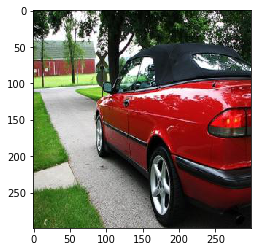

In [4]:
# %load solutions/predict_image.py
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

path = "images_resize/000007.jpg"

img = imread(path)
plt.imshow(img)

img = resize(img, (224, 224), mode='reflect', preserve_range=True,
             anti_aliasing=True)
# add a dimension for a "batch" of 1 image
img_batch = preprocess_input(img[np.newaxis]) 

predictions = model.predict(img_batch)
decoded_predictions= decode_predictions(predictions)

for s, name, score in decoded_predictions[0]:
    print(name, score)

### Computing the representation of an image

In [5]:
input = model.layers[0].input
output = model.layers[-2].output
base_model = Model(input, output)

In [6]:
output.shape

TensorShape([Dimension(None), Dimension(2048)])

In [7]:
representation = base_model.predict(img_batch)
print("shape of representation:", representation.shape)
print("proportion of zero valued axis: %0.3f"
      % np.mean(representation[0]==0))

shape of representation: (1, 2048)
proportion of zero valued axis: 0.118


Computing representations of all images can be time consuming.
This is usually made by large batches on a GPU for massive performance gains.

For the remaining part, we will use pre-computed representations saved in h5 format

For those interested, this is done using the `process_images.py` script

In [8]:
import os
paths = ["images_resize/" + path
         for path in sorted(os.listdir("images_resize/"))]

In [10]:
import h5py

# Load pre-calculated representations
h5f = h5py.File('img_emb.h5','r')
out_tensors = h5f['img_emb'][:]
h5f.close()

The representations are dense. 

**Exercise**
- Which proportion of a representation is 0? 
- Why are there null values?

proportion of zeros (first image): 0.15380859375
proportion of strictly negative values: 0.0


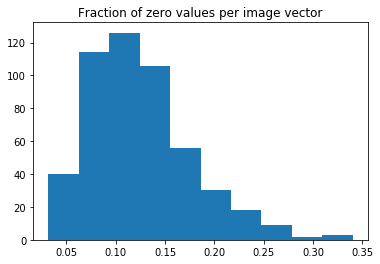

In [11]:
# %load solutions/representations.py
# Proportion of zeros in the vector of the first image:
print("proportion of zeros (first image):", np.mean(out_tensors[0] == 0.0))

# Proportion of negative values in the full representation tensor
print("proportion of strictly negative values:", np.mean(out_tensors < 0.0))

# For all representations:
plt.hist(np.mean(out_tensors == 0.0, axis=1))
plt.title("Fraction of zero values per image vector");

# These 0 values come from the different ReLU units.
# They propagate through the layers, and there can be many.
# If a network has too many of them, a lot of computation
# / memory is wasted.

In [12]:
from sklearn.manifold import TSNE

img_emb_tsne = TSNE(perplexity=30).fit_transform(out_tensors)

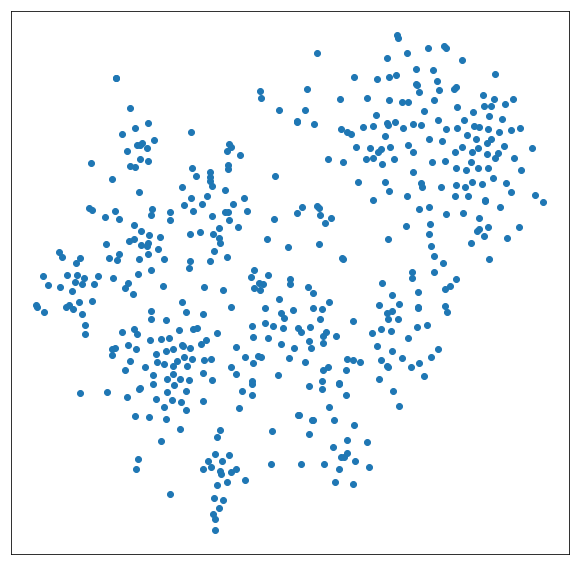

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(img_emb_tsne[:, 0], img_emb_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

Let's add thumnails of the original images at their TSNE locations:

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.misc import imread, imresize

def imscatter(x, y, paths, ax=None, zoom=1, linewidth=0):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, p in zip(x, y, paths):
        try:
            im = imread(p)
        except:
            print(p)
            continue
        im = imresize(im,(224,224))
        im = OffsetImage(im, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data',
                            frameon=True, pad=0.1, 
                            bboxprops=dict(edgecolor='red',
                                           linewidth=linewidth))
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

/home/lemaitre/miniconda3/envs/ibiom/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/home/lemaitre/miniconda3/envs/ibiom/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


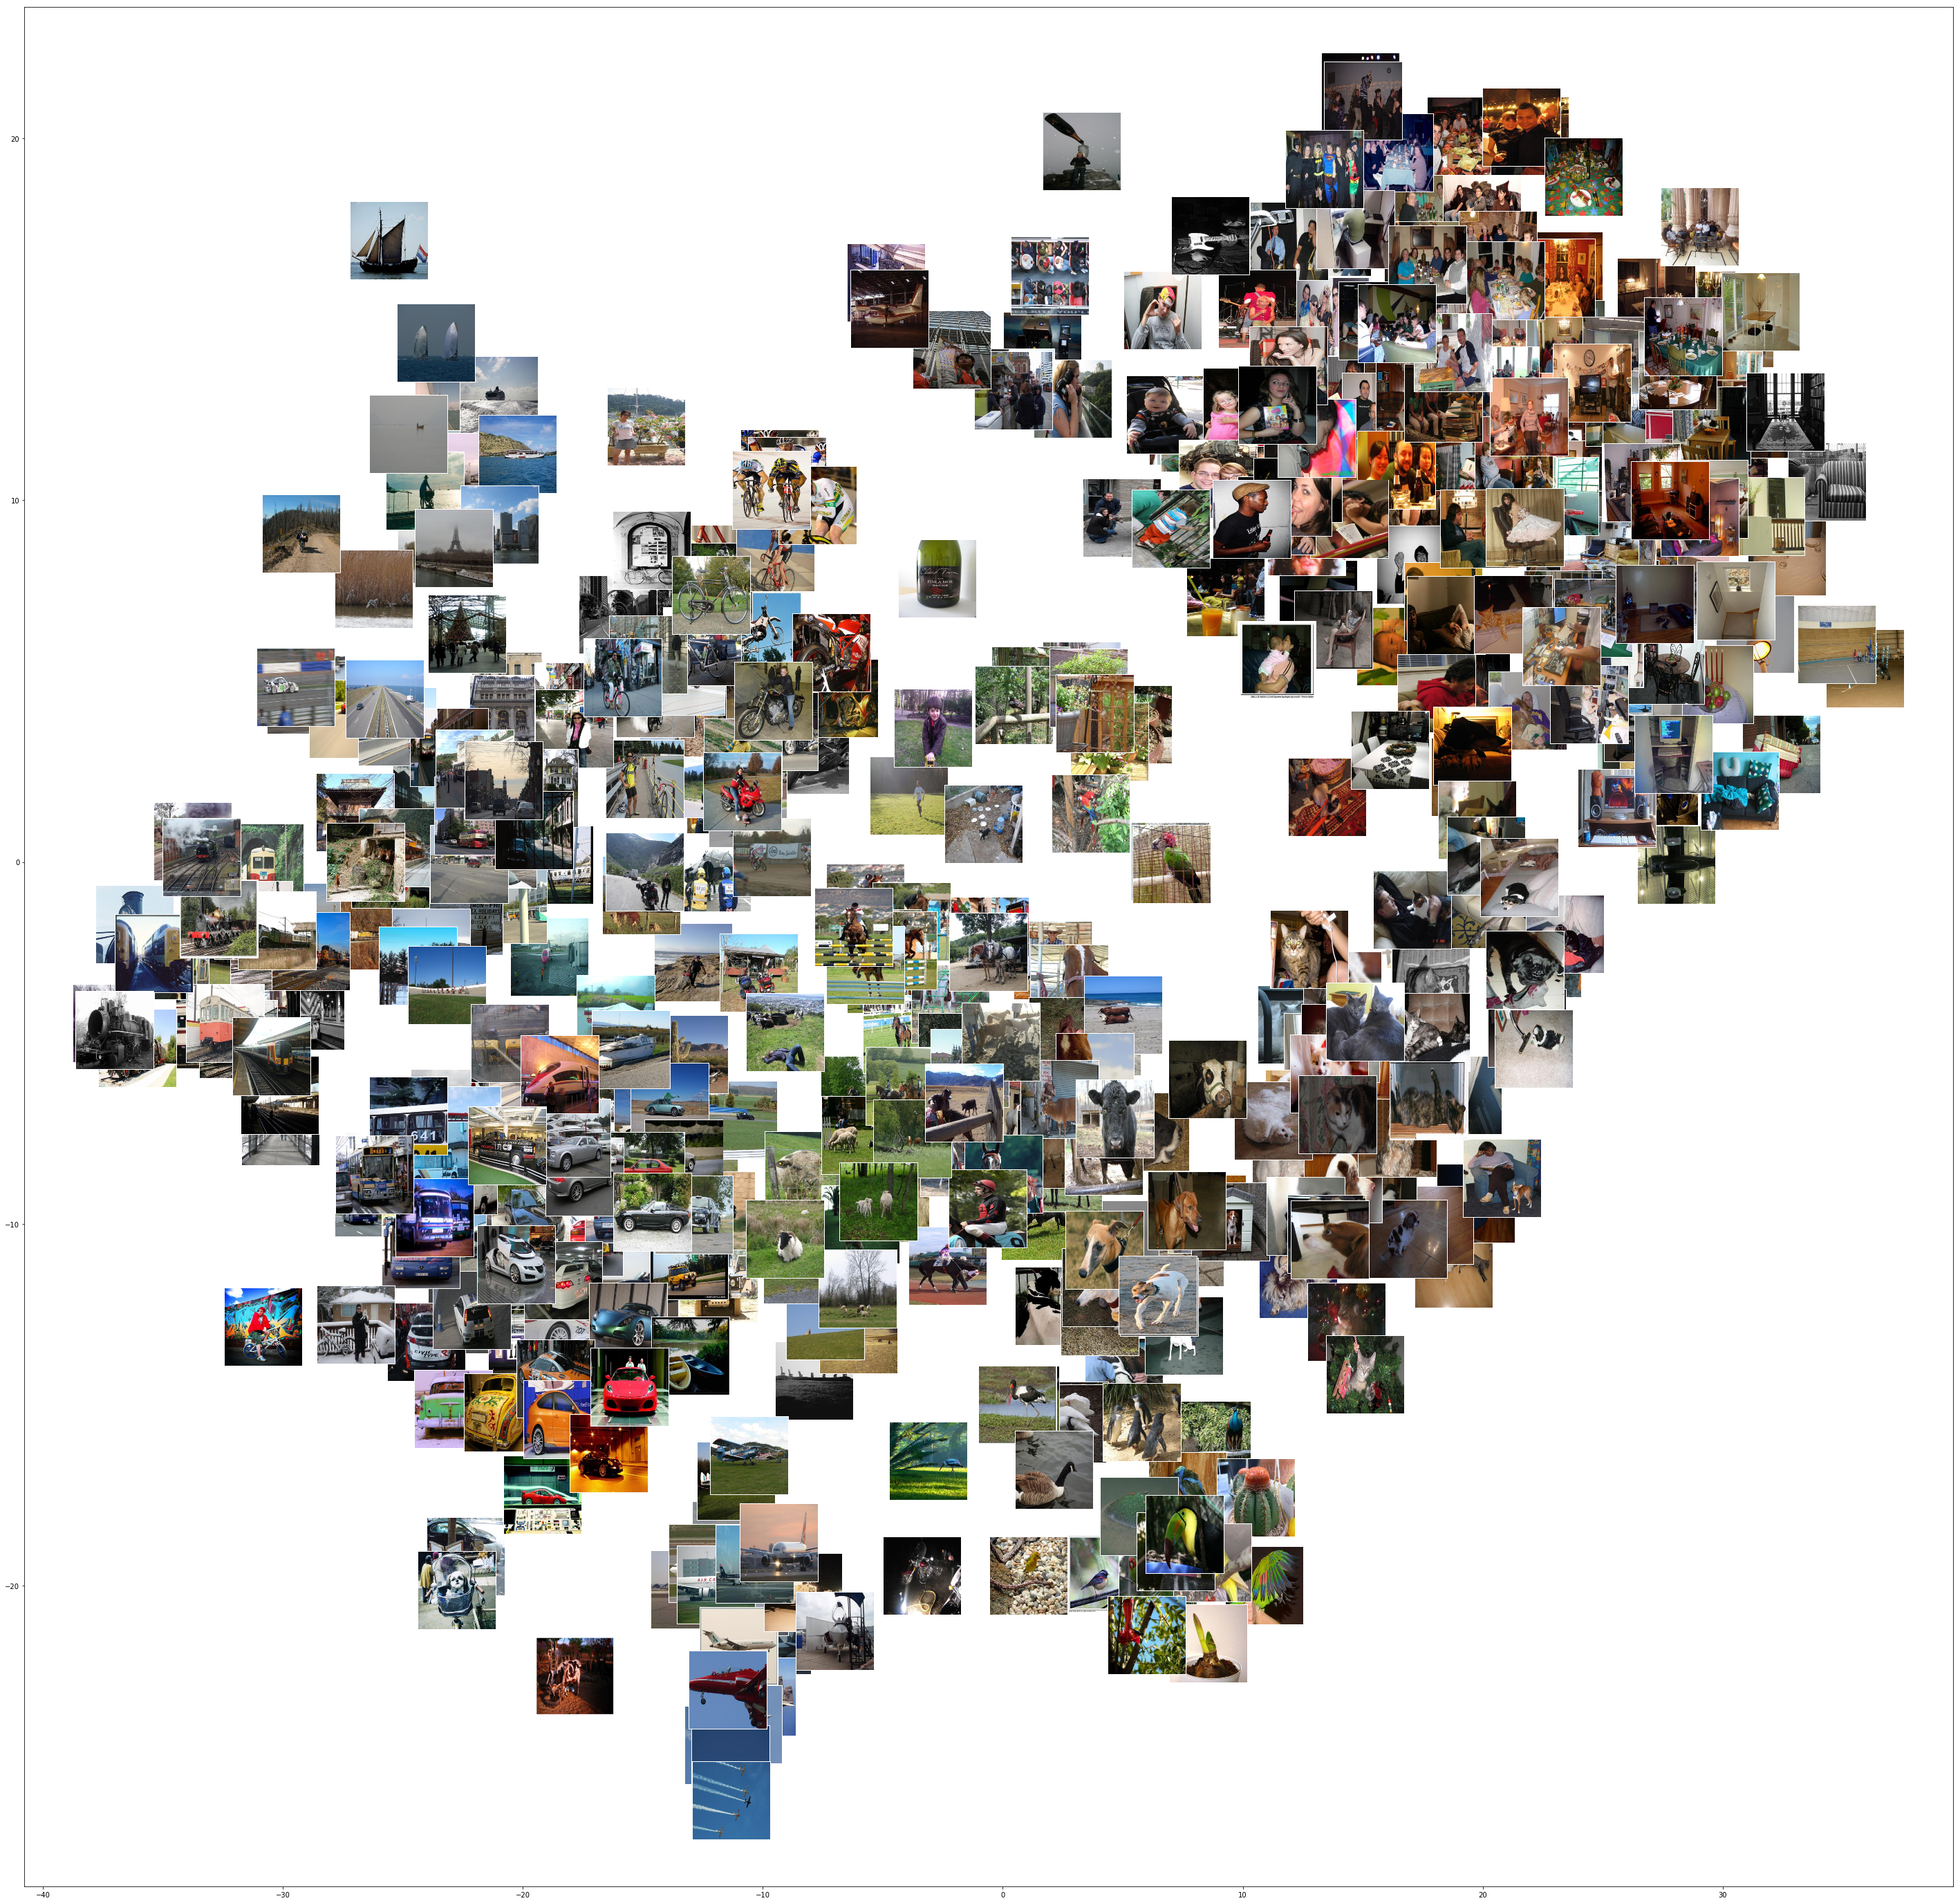

In [15]:
fig, ax = plt.subplots(figsize=(50, 50))
imscatter(img_emb_tsne[:, 0], img_emb_tsne[:, 1], paths, zoom=0.5, ax=ax)
plt.savefig('tsne.png')

### Visual Search: finding similar images

In [16]:
def display(img):
    plt.figure()
    img = imread(img)
    plt.imshow(img)

/home/lemaitre/miniconda3/envs/ibiom/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


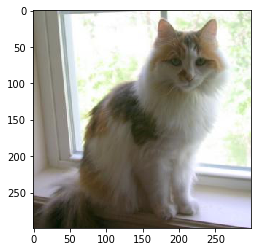

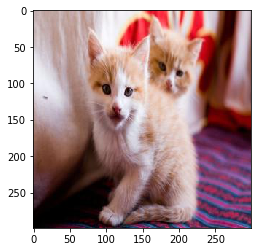

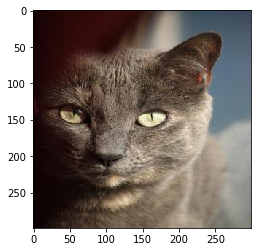

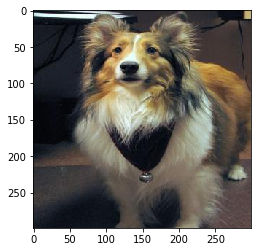

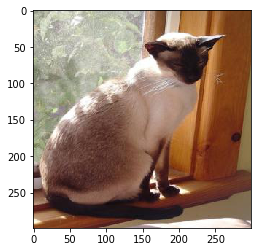

In [17]:
idx = 57

def most_similar(idx, top_n=5):
    dists = np.linalg.norm(out_tensors - out_tensors[idx], axis = 1)
    sorted_dists = np.argsort(dists)
    return sorted_dists[:top_n]

sim = most_similar(idx)
[display(paths[s]) for s in sim];